# **Dynamic Reorder Point Optimization Predicting Sales Quantity**

## **Install & Import Libraries**

In [1]:
# Step 1: Install & Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix

In [2]:
# Optional: set plot style
sns.set(style="whitegrid")  # apply whitegrid style for seaborn plots

## **Load Data**

In [4]:
#Step 2: Load data
demand_df = pd.read_csv("/content/demand_forecasting.csv")
inventory_df = pd.read_csv("/content/inventory_monitoring.csv")

In [5]:
demand_df

,Product ID,Date,Store ID,Sales Quantity,Price,Promotions,Seasonality Factors,External Factors,Demand Trend,Customer Segments
0,4277,2024-01-03,48,330,24.38,No,Festival,Competitor Pricing,Increasing,Regular
1,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium
2,5406,2024-01-11,67,429,24.83,Yes,Holiday,Economic Indicator,Decreasing,Premium
3,5617,2024-04-04,17,298,13.41,No,NaN,Economic Indicator,Stable,Regular
4,3480,2024-12-14,33,344,94.96,Yes,Festival,Weather,Increasing,Regular
...,...,...,...,...,...,...,...,...,...,...
9995,6545,2024-11-26,54,47,47.12,No,NaN,Competitor Pricing,Decreasing,Budget
9996,4341,2024-04-08,82,59,65.11,No,Festival,NaN,Increasing,Budget
9997,8679,2024-02-16,55,481,59.97,No,Holiday,Economic Indicator,Stable,Premium
9998,6281,2024-02-15,97,142,48.70,No,Festival,NaN,Decreasing,Regular


In [6]:
inventory_df

,Product ID,Store ID,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days)
0,9286,16,700,10,14,132,2024-01-15,1052,6
1,2605,60,82,11,1,127,2024-12-16,1262,9
2,2859,55,145,25,14,192,2024-04-30,1457,12
3,2374,24,151,17,6,19,2024-12-16,2944,3
4,7678,5,714,12,2,21,2024-08-05,3739,7
...,...,...,...,...,...,...,...,...,...
9995,9337,27,860,27,19,96,2024-04-30,4025,12
9996,5907,90,282,25,19,173,2024-03-18,4983,2
9997,6159,7,352,4,6,123,2024-04-23,3517,13
9998,1564,14,325,10,14,153,2024-06-24,4868,1


In [7]:
demand_df['Date'] = pd.to_datetime(demand_df['Date'])
inventory_df['Expiry Date'] = pd.to_datetime(inventory_df['Expiry Date'])

In [8]:
# Create unique combinations
demand_keys = set(zip(demand_df["Product ID"], demand_df["Store ID"]))
inventory_keys = set(zip(inventory_df["Product ID"], inventory_df["Store ID"]))

# Check how many combinations match
matching_keys = demand_keys.intersection(inventory_keys)
print(f"Matching combinations: {len(matching_keys)}")


Matching combinations: 121


In [9]:
# Create sets of unique keys
product_store_demand = set(zip(demand_df["Product ID"], demand_df["Store ID"]))
product_store_inventory = set(zip(inventory_df["Product ID"], inventory_df["Store ID"]))

# Matching keys when merging on BOTH Product ID + Store ID
matching_keys_both = product_store_demand & product_store_inventory
print(f"🔗 Matching rows on [Product ID + Store ID]: {len(matching_keys_both)}")

# Merge on BOTH keys
merge_both = pd.merge(demand_df, inventory_df, on=["Product ID", "Store ID"])
print(f"📏 Merge on BOTH keys: {merge_both.shape[0]} rows")

# Merge on only Product ID
merge_product = pd.merge(demand_df, inventory_df, on="Product ID")
print(f"📏 Merge on only Product ID: {merge_product.shape[0]} rows")

# Check for duplicate or mismatched Store IDs in the product-only merge
store_match_rate = (merge_product["Store ID_x"] == merge_product["Store ID_y"]).mean()
print(f"✅ Store ID match rate in Product-ID-only merge: {store_match_rate:.2%}")


🔗 Matching rows on [Product ID + Store ID]: 121
📏 Merge on BOTH keys: 122 rows
📏 Merge on only Product ID: 11375 rows
✅ Store ID match rate in Product-ID-only merge: 1.07%


In [10]:
# Merge data on 'Product ID' only
merged_df = pd.merge(demand_df, inventory_df, on="Product ID")

In [11]:
# Preview structure
merged_df

,Product ID,Date,Store ID_x,Sales Quantity,Price,Promotions,Seasonality Factors,External Factors,Demand Trend,Customer Segments,Store ID_y,Stock Levels,Supplier Lead Time (days),Stockout Frequency,Reorder Point,Expiry Date,Warehouse Capacity,Order Fulfillment Time (days)
0,4277,2024-01-03,48,330,24.38,No,Festival,Competitor Pricing,Increasing,Regular,44,10,4,10,19,2024-04-15,1504,8
1,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium,81,966,29,0,12,2024-07-21,4959,7
2,5540,2024-04-29,10,334,74.98,Yes,Holiday,Weather,Stable,Premium,20,73,9,1,169,2024-02-23,2964,6
3,5406,2024-01-11,67,429,24.83,Yes,Holiday,Economic Indicator,Decreasing,Premium,89,296,2,10,128,2024-11-28,3169,6
4,5617,2024-04-04,17,298,13.41,No,NaN,Economic Indicator,Stable,Regular,30,807,26,17,195,2024-11-20,3533,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11370,6545,2024-11-26,54,47,47.12,No,NaN,Competitor Pricing,Decreasing,Budget,68,223,13,13,127,2024-05-26,2244,12
11371,6545,2024-11-26,54,47,47.12,No,NaN,Competitor Pricing,Decreasing,Budget,76,7,6,4,42,2024-04-12,2432,6
11372,4341,2024-04-08,82,59,65.11,No,Festival,NaN,Increasing,Budget,49,766,15,4,125,2024-01-30,1223,14
11373,6281,2024-02-15,97,142,48.70,No,Festival,NaN,Decreasing,Regular,96,125,13,9,146,2024-04-09,2325,12


📦 **1. Demand Forecasting (demand_forecasting.csv)**

| Column Name             | Description                            |
|-------------------------|----------------------------------------|
| Product ID, Store ID    | Product and store identifiers          |
| Date                    | Transaction date                       |
| Sales Quantity          | Number of units sold                   |
| Price, Promotions       | Price and promotion info               |
| Seasonality Factors     | Holidays, festivals, etc.              |
| External Factors        | Weather, competition, economy          |
| Demand Trend            | Increasing, Stable, Decreasing         |
| Customer Segments       | Regular, Premium, etc.                 |


**🗃️ 2. Inventory Monitoring (inventory_monitoring.csv)**

| Column Name                  | Description                            |
|------------------------------|----------------------------------------|
| Stock Levels                 | Current stock per product/store        |
| Supplier Lead Time (days)    | Avg days supplier takes to deliver     |
| Stockout Frequency           | How often the item runs out            |
| Reorder Point, Expiry Date   | Reordering and expiration info         |
| Warehouse Capacity           | How much space is available            |
| Order Fulfillment Time (days)| Time to complete an order              |


In [12]:
# Preview structure
merged_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11375 entries, 0 to 11374
Data columns (total 18 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Product ID                     11375 non-null  int64         
 1   Date                           11375 non-null  datetime64[ns]
 2   Store ID_x                     11375 non-null  int64         
 3   Sales Quantity                 11375 non-null  int64         
 4   Price                          11375 non-null  float64       
 5   Promotions                     11375 non-null  object        
 6   Seasonality Factors            7634 non-null   object        
 7   External Factors               8588 non-null   object        
 8   Demand Trend                   11375 non-null  object        
 9   Customer Segments              11375 non-null  object        
 10  Store ID_y                     11375 non-null  int64         
 11  Stock Levels   

## **Visualization**

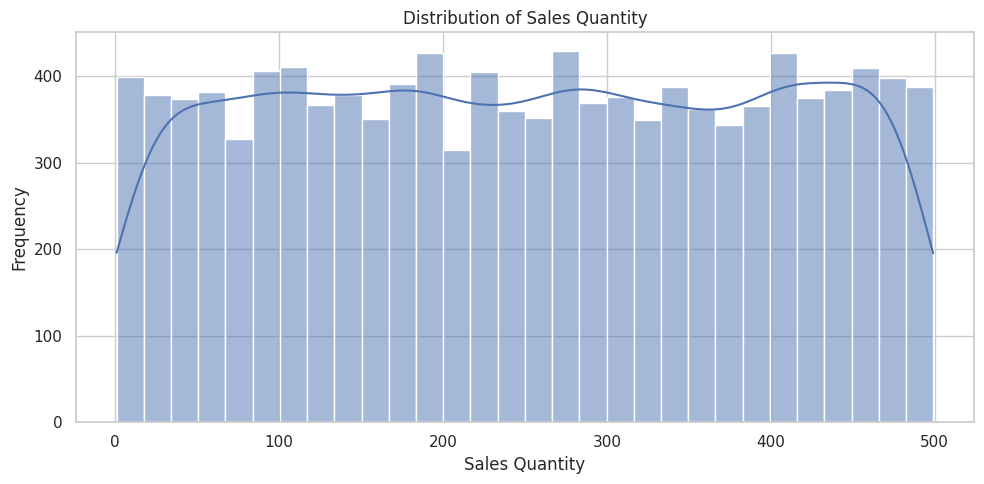

In [13]:
plt.figure(figsize=(10,5))
sns.histplot(merged_df['Sales Quantity'], bins=30, kde=True)
plt.title('Distribution of Sales Quantity')
plt.xlabel('Sales Quantity')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()  # view how demand is distributed overall

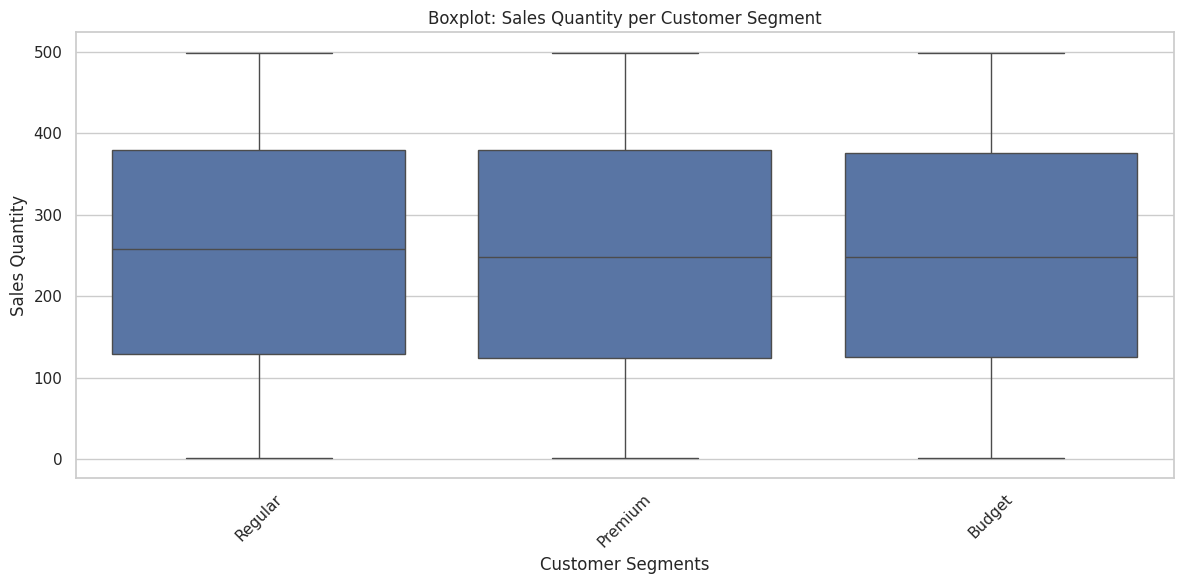

In [14]:
plt.figure(figsize=(12,6))
sns.boxplot(x='Customer Segments', y='Sales Quantity', data=merged_df)
plt.title('Boxplot: Sales Quantity per Customer Segment')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()  # understand variations by customer segment

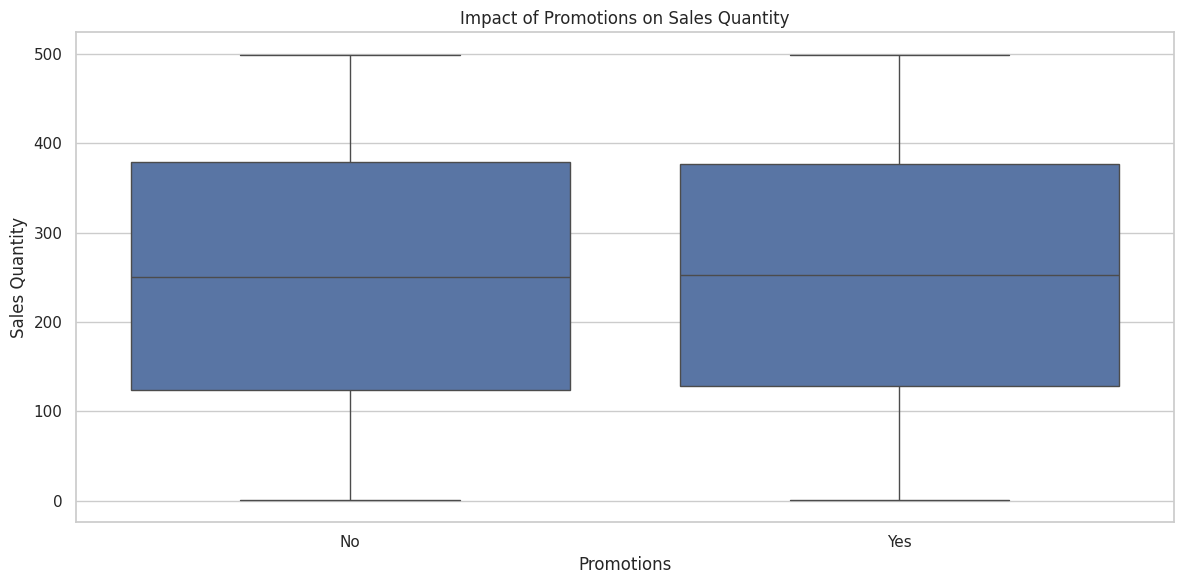

In [15]:

plt.figure(figsize=(12,6))
sns.boxplot(x='Promotions', y='Sales Quantity', data=merged_df)
plt.title('Impact of Promotions on Sales Quantity')
plt.tight_layout()
plt.show()  # assess how promotions affect sales

<ipython-input-16-bca7f4920e31>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='Seasonality Factors', y='Sales Quantity', estimator=np.mean, ci=None)


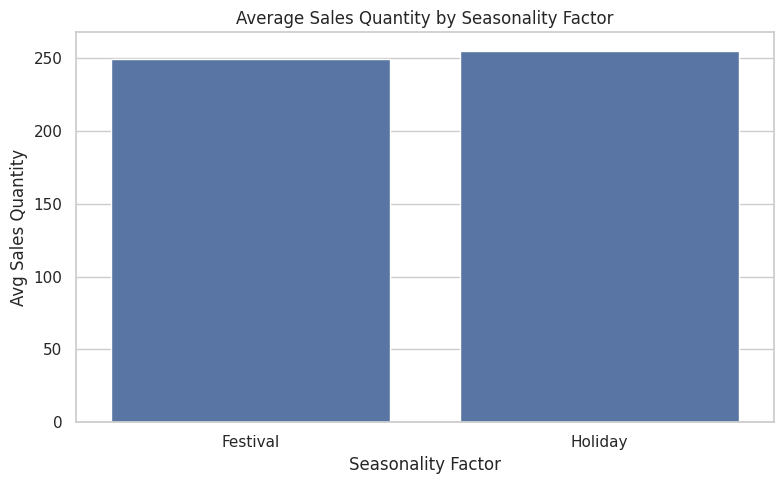

<ipython-input-16-bca7f4920e31>:12: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='External Factors', y='Sales Quantity', estimator=np.mean, ci=None)


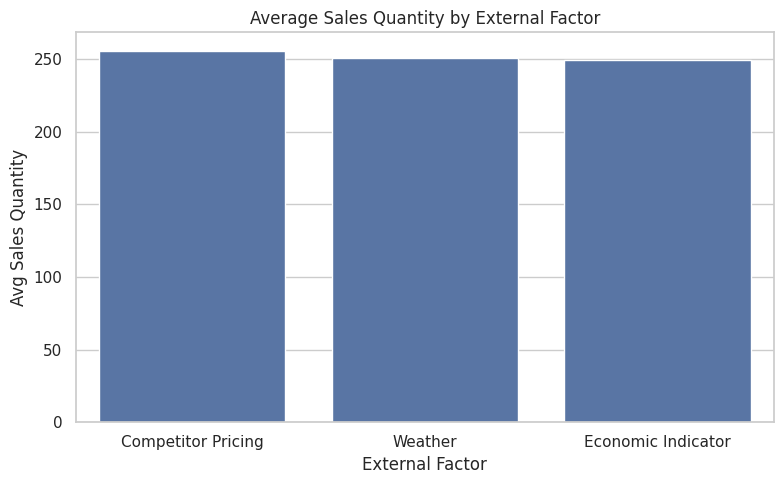

In [16]:

#barplot: average sales quantity by seasonality factor
plt.figure(figsize=(8,5))
sns.barplot(data=merged_df, x='Seasonality Factors', y='Sales Quantity', estimator=np.mean, ci=None)
plt.title('Average Sales Quantity by Seasonality Factor')
plt.ylabel('Avg Sales Quantity')
plt.xlabel('Seasonality Factor')
plt.tight_layout()
plt.show()

# barplot: average sales quantity by external factor
plt.figure(figsize=(8,5))
sns.barplot(data=merged_df, x='External Factors', y='Sales Quantity', estimator=np.mean, ci=None)
plt.title('Average Sales Quantity by External Factor')
plt.ylabel('Avg Sales Quantity')
plt.xlabel('External Factor')
plt.tight_layout()
plt.show()

## **Preprocessing and Feature Engineering**

In [17]:
#Clean and Prepare Demand Data

#Fill missing categorical values
for col in ['Seasonality Factors', 'External Factors']:
    merged_df[col] = merged_df[col].fillna('Unknown')

In [18]:
#Feature engineering
merged_df['Year'] = merged_df['Date'].dt.year
merged_df['Month'] = merged_df['Date'].dt.month
merged_df['Day'] = merged_df['Date'].dt.day
merged_df['IsWeekend'] = merged_df['Date'].dt.weekday >= 5

#Calculate demand statistics per Product ID
demand_stats = merged_df.groupby('Product ID')['Sales Quantity'].agg(
    Avg_Demand='mean',
    Demand_Std='std'
).reset_index()

# Merge stats back to merged_df
merged_df = pd.merge(merged_df, demand_stats, on='Product ID')

In [19]:
#Calculate Safety Stock and Dynamic Reorder Point
merged_df['Safety Stock'] = merged_df['Demand_Std'] * np.sqrt(merged_df['Supplier Lead Time (days)'])
merged_df['Calc Reorder Point'] = (merged_df['Avg_Demand'] * merged_df['Supplier Lead Time (days)']) + merged_df['Safety Stock']


In [20]:
# Encode categorical features
label_encoders = {}
categorical_cols = merged_df.select_dtypes(include='object').columns

for col in categorical_cols:
    le = LabelEncoder()
    merged_df[col] = le.fit_transform(merged_df[col])
    label_encoders[col] = le

# Check the result
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11375 entries, 0 to 11374
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Product ID                     11375 non-null  int64         
 1   Date                           11375 non-null  datetime64[ns]
 2   Store ID_x                     11375 non-null  int64         
 3   Sales Quantity                 11375 non-null  int64         
 4   Price                          11375 non-null  float64       
 5   Promotions                     11375 non-null  int64         
 6   Seasonality Factors            11375 non-null  int64         
 7   External Factors               11375 non-null  int64         
 8   Demand Trend                   11375 non-null  int64         
 9   Customer Segments              11375 non-null  int64         
 10  Store ID_y                     11375 non-null  int64         
 11  Stock Levels   

In [21]:
merged_df['Product ID'].value_counts()

,count
Product ID,
7839,20
4584,20
1589,20
6081,16
9309,16
...,...
6555,1
5101,1
4268,1


In [22]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11375 entries, 0 to 11374
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Product ID                     11375 non-null  int64         
 1   Date                           11375 non-null  datetime64[ns]
 2   Store ID_x                     11375 non-null  int64         
 3   Sales Quantity                 11375 non-null  int64         
 4   Price                          11375 non-null  float64       
 5   Promotions                     11375 non-null  int64         
 6   Seasonality Factors            11375 non-null  int64         
 7   External Factors               11375 non-null  int64         
 8   Demand Trend                   11375 non-null  int64         
 9   Customer Segments              11375 non-null  int64         
 10  Store ID_y                     11375 non-null  int64         
 11  Stock Levels   

In [23]:
#Drop rows with any missing values
merged_df = merged_df.dropna()

## **Split Data**

In [24]:
# Define features (X) and target (y)

y = merged_df["Sales Quantity"]

# Features: drop Sales Quantity and formula-based columns
X = merged_df.drop(columns=["Sales Quantity", "Calc Reorder Point", "ROP_traditional", "Reorder Point", "Date", "Expiry Date"], errors="ignore")


In [25]:
# Split into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)


# Confirm shapes
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_train:", y_train.shape)
print("y_test :", y_test.shape)

X_train: (8115, 21)
X_test : (2029, 21)
y_train: (8115,)
y_test : (2029,)


## **Build Model**

### **Linear Regression**

In [26]:
#Train Linear Regression model
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression()

In [27]:
# Predict
y_pred_lr = lr.predict(X_test)

y_pred_lr

array([319.97904449, 177.39950702, 226.01631495, ..., 389.21109216,
       191.17967416, 256.7890566 ])

📊 Linear Regression Results
R² Score: 0.5715
RMSE: 95.18
Accuracy: 57.15 %


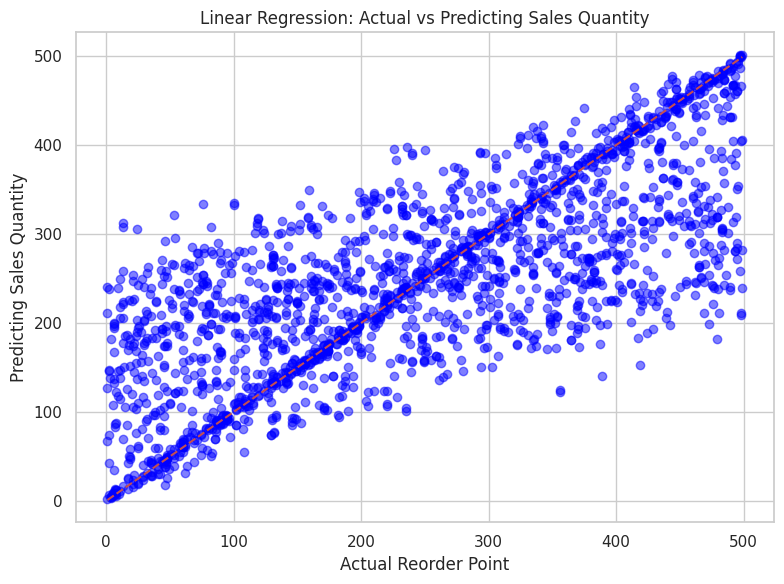

In [29]:
# Evaluate performance
print("📊 Linear Regression Results")
print("R² Score:", round(r2_score(y_test, y_pred_lr), 4))
print("RMSE:", round(mean_squared_error(y_test, y_pred_lr) ** 0.5, 2))
print("Accuracy:", round(lr.score(X_test, y_test) * 100, 2), "%")

# Visualize: Actual vs Predicted
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_lr, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Reorder Point")
plt.ylabel("Predicting Sales Quantity")
plt.title("Linear Regression: Actual vs Predicting Sales Quantity")
plt.tight_layout()
plt.show()

### **Random Forest**

📊 Random Forest Results
R² Score: 0.6459
RMSE: 86.53
Accuracy: 64.59 %


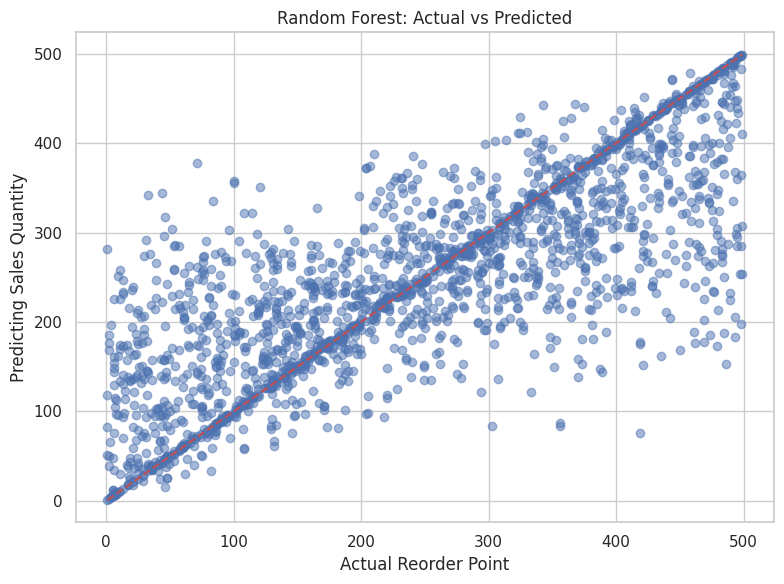

In [30]:
# Train Random Forest model
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred_rf = rf.predict(X_test)

# Evaluate
print("📊 Random Forest Results")
print("R² Score:", round(r2_score(y_test, y_pred_rf), 4))
print("RMSE:", round(mean_squared_error(y_test, y_pred_rf) ** 0.5, 2))
print("Accuracy:", round(rf.score(X_test, y_test) * 100, 2), "%")

# Visualize
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred_rf, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Reorder Point")
plt.ylabel("Predicting Sales Quantity")
plt.title("Random Forest: Actual vs Predicted")
plt.tight_layout()
plt.show()


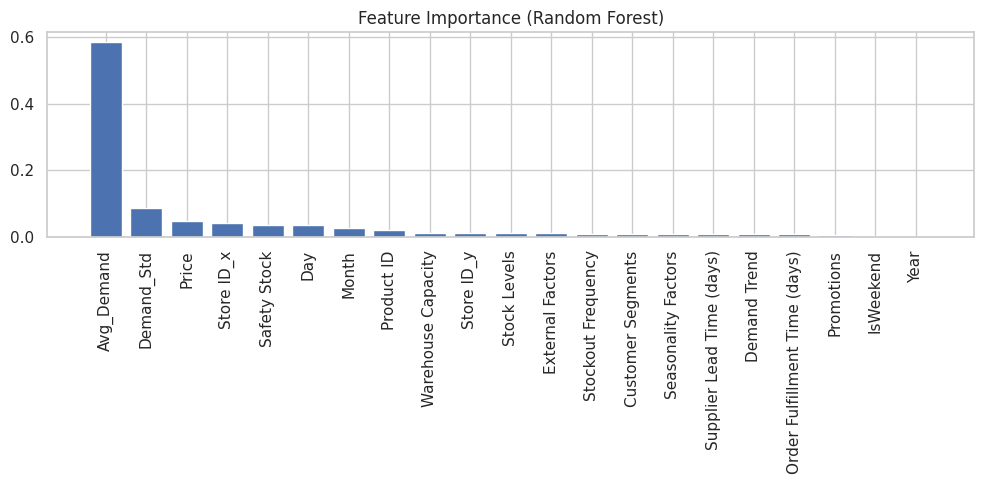

In [31]:
# Feature importances
importances = rf.feature_importances_
features = X.columns
sorted_idx = np.argsort(importances)[::-1]

# Plot
plt.figure(figsize=(10, 5))
plt.bar(range(len(importances)), importances[sorted_idx], align="center")
plt.xticks(range(len(importances)), features[sorted_idx], rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()


### **Gradient Boosting**

Gradient Boosting Results
R² Score: 0.5492
RMSE: 9531.31


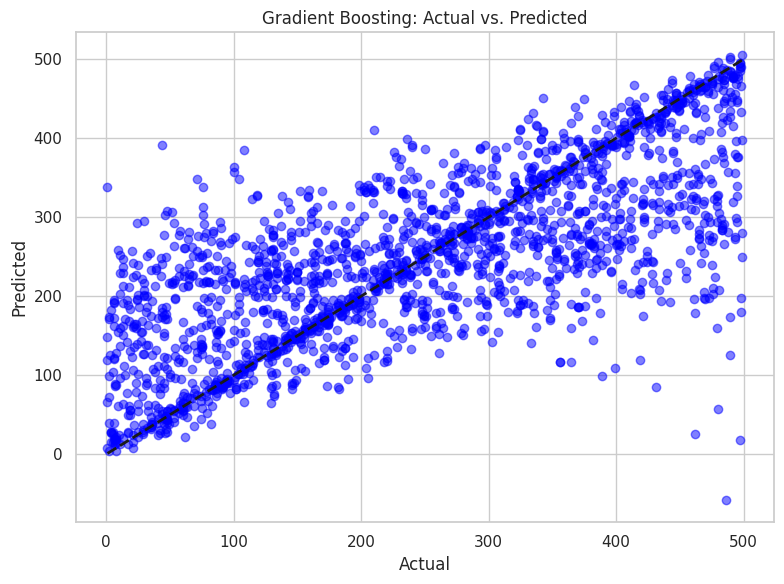

In [32]:
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=200, learning_rate=0.1, random_state=42)
gb.fit(X_train, y_train)
y_pred_gb = gb.predict(X_test)

#Evaluate model
r2 = r2_score(y_test, y_pred_gb)
rmse = mean_squared_error(y_test, y_pred_gb)

print("Gradient Boosting Results")
print("R² Score:", round(r2, 4))
print("RMSE:", round(rmse, 2))

#Plot Actual vs Predicted
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_gb, alpha=0.5, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Gradient Boosting: Actual vs. Predicted")
plt.tight_layout()
plt.show()


## **Predictions and Evaluation**

In [42]:
#Traditional Method - Predict demand as Avg_Demand
traditional_pred = X_test['Avg_Demand']
print(traditional_pred)

9413     323.000000
6257     180.333333
1222     220.000000
11083    198.000000
10312    212.000000
            ...    
9196      42.000000
1950     435.000000
3229     394.750000
8831     192.500000
3721     258.666667
Name: Avg_Demand, Length: 2029, dtype: float64


In [43]:
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'Gradient Boosting', 'Traditional (Avg Demand)'],
    'R² Score': [
        round(r2_score(y_test, y_pred_lr), 4),
        round(r2_score(y_test, y_pred_rf), 4),
        round(r2_score(y_test, y_pred_gb), 4),
        round(r2_score(y_test, traditional_pred), 4)
    ],
    'RMSE': [
        round(np.sqrt(mean_squared_error(y_test, y_pred_lr)), 2),
        round(np.sqrt(mean_squared_error(y_test, y_pred_rf)), 2),
        round(np.sqrt(mean_squared_error(y_test, y_pred_gb)), 2),
        round(np.sqrt(mean_squared_error(y_test, traditional_pred)), 2)
    ]
})

print("\n📋 Model Comparison - Predicting Actual Demand (Sales Quantity):")
print(results.to_string(index=False))


📋 Model Comparison - Predicting Actual Demand (Sales Quantity):
                   Model  R² Score  RMSE
       Linear Regression    0.5715 95.18
           Random Forest    0.6459 86.53
       Gradient Boosting    0.5492 97.63
Traditional (Avg Demand)    0.5735 94.96


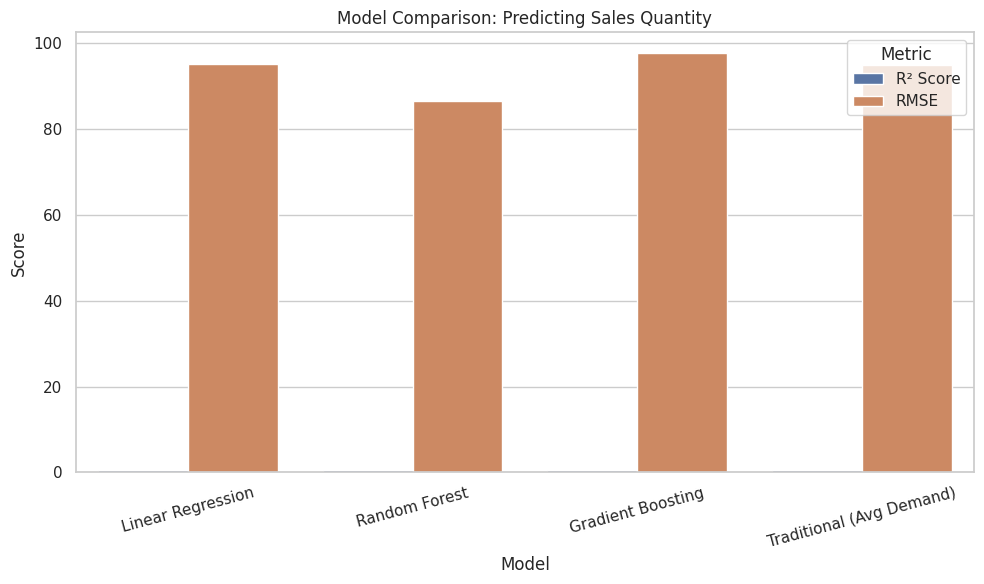

In [44]:
#Visualize Comparison
melted_results = results.melt(id_vars='Model', var_name='Metric', value_name='Score')
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_results, x='Model', y='Score', hue='Metric')
plt.title("Model Comparison: Predicting Sales Quantity")
plt.ylabel("Score")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()

<ipython-input-35-eae7b48ac281>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="R² Score", data=results_df, palette="Blues_d")
<ipython-input-35-eae7b48ac281>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="RMSE", data=results_df, palette="Reds_d")
<ipython-input-35-eae7b48ac281>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Model", y="Accuracy (%)", data=results_df, palette="Greens_d")


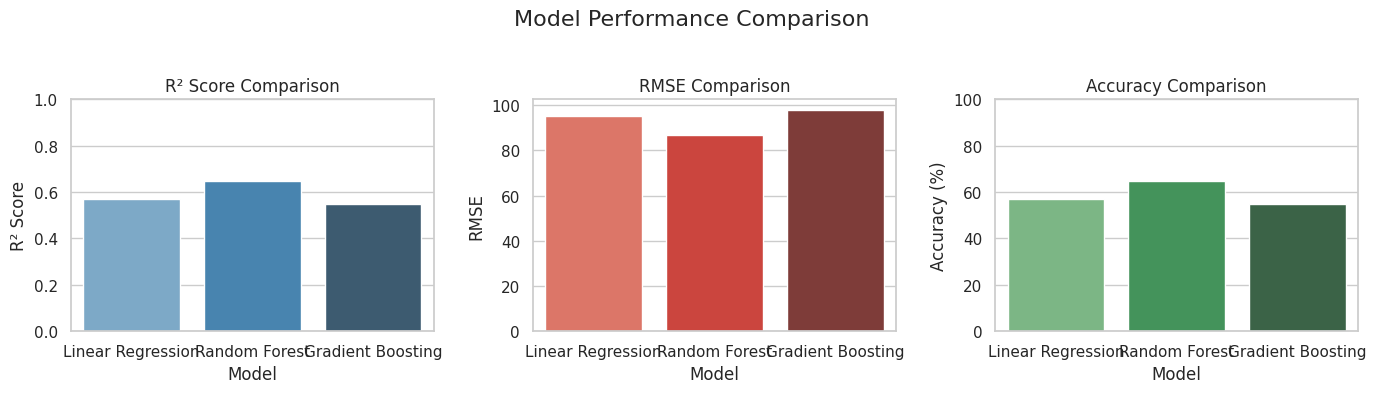

In [35]:
# 📊 Bar Chart Comparison
plt.figure(figsize=(14, 4))

# R² Score
plt.subplot(1, 3, 1)
sns.barplot(x="Model", y="R² Score", data=results_df, palette="Blues_d")
plt.title("R² Score Comparison")
plt.ylim(0, 1)

# RMSE
plt.subplot(1, 3, 2)
sns.barplot(x="Model", y="RMSE", data=results_df, palette="Reds_d")
plt.title("RMSE Comparison")

# Accuracy
plt.subplot(1, 3, 3)
sns.barplot(x="Model", y="Accuracy (%)", data=results_df, palette="Greens_d")
plt.title("Accuracy Comparison")
plt.ylim(0, 100)

plt.suptitle("Model Performance Comparison", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## **Visualize Differences (ML vs Traditional)**

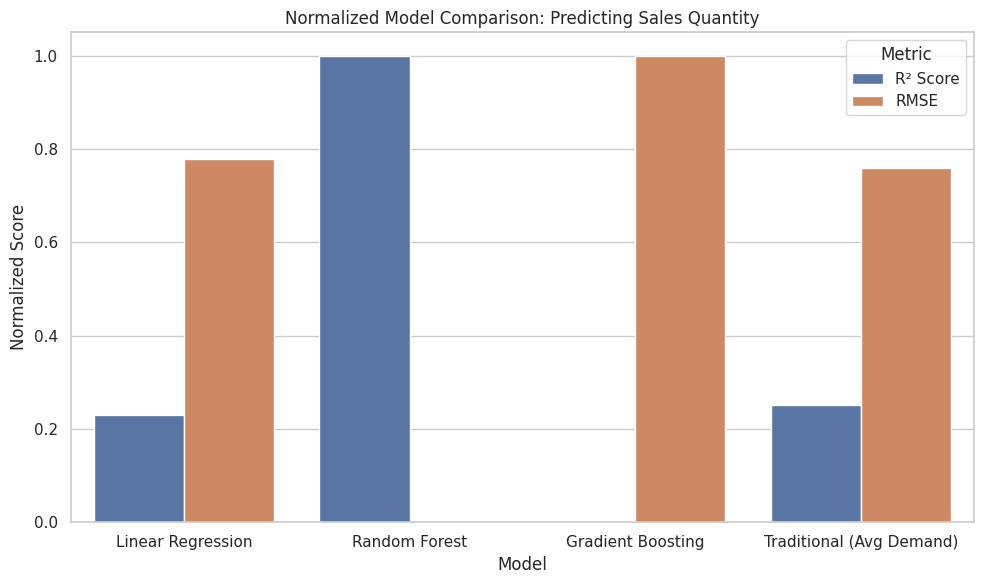

In [45]:
# Normalize scores between 0 and 1
normalized_results = results.copy()
for col in ["R² Score", "RMSE"]:
    min_val = normalized_results[col].min()
    max_val = normalized_results[col].max()
    normalized_results[col] = (normalized_results[col] - min_val) / (max_val - min_val)

# Melt and plot
melted_norm = normalized_results.melt(id_vars='Model', var_name='Metric', value_name='Normalized Score')
plt.figure(figsize=(10, 6))
sns.barplot(data=melted_norm, x='Model', y='Normalized Score', hue='Metric')
plt.title("Normalized Model Comparison: Predicting Sales Quantity")
plt.tight_layout()
plt.show()


In [46]:
# Calculate absolute error per row for Random Forest
comparison_df = pd.DataFrame({
    "Actual": y_test,
    "RF_Prediction": y_pred_rf
})
comparison_df["Absolute_Error"] = abs(comparison_df["Actual"] - comparison_df["RF_Prediction"])

# Sort by highest error
top_errors = comparison_df.sort_values(by="Absolute_Error", ascending=False).head(10)

print("🔍 Top 10 Highest Errors in Random Forest Predictions:")
print(top_errors)


🔍 Top 10 Highest Errors in Random Forest Predictions:
      Actual  RF_Prediction  Absolute_Error
7160     419          75.68          343.32
1174     486         152.95          333.05
667       33         342.54          309.54
5480     493         183.55          309.45
35        71         377.33          306.33
4400     479         173.00          306.00
515       44         344.20          300.20
836      498         198.17          299.83
3078     485         187.46          297.54
3381     469         177.47          291.53


<ipython-input-47-36e4755b02dd>:12: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


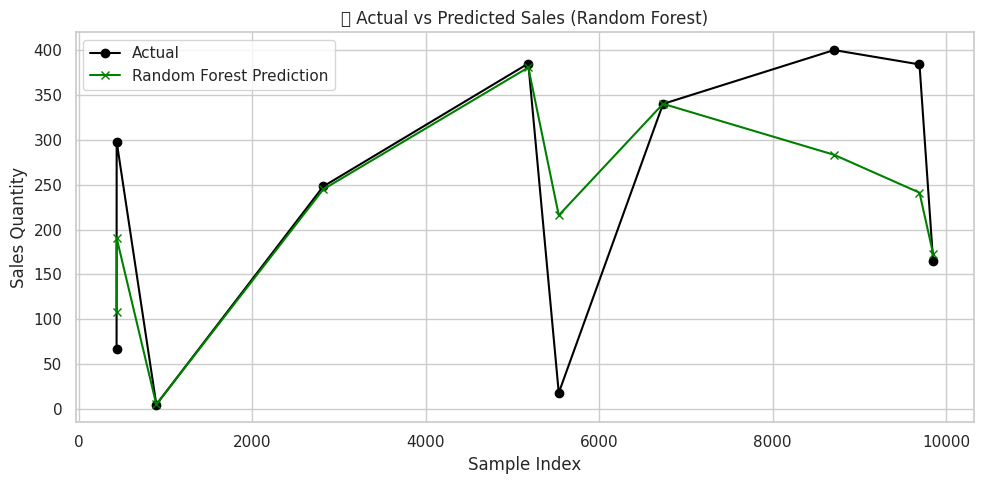

In [47]:
# Pick a random sample of 10 rows from test set
sample = comparison_df.sample(10, random_state=42).sort_index()

# Plot
plt.figure(figsize=(10, 5))
plt.plot(sample.index, sample["Actual"], marker='o', label="Actual", color='black')
plt.plot(sample.index, sample["RF_Prediction"], marker='x', label="Random Forest Prediction", color='green')
plt.title("📈 Actual vs Predicted Sales (Random Forest)")
plt.xlabel("Sample Index")
plt.ylabel("Sales Quantity")
plt.legend()
plt.tight_layout()
plt.show()
